In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
# Importing playlist dataframes
df = pd.read_csv('Track Data Files for ML\DonaldMarch22ML.csv')
df_fav = pd.read_csv('Track Data Files for ML\SpotifyMarch22ML.csv')

In [3]:
# Checking if both datasets have the same columns
df.columns == df_fav.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [4]:
df_model = pd.concat([df, df_fav], axis=0)
df_model = df_model.reset_index(drop=True)
df_model.shape

(6464, 13)

In [5]:
df_model.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
0,0V5UDz8WFKsWg2IdrNrwhs,235668,17,0.682,0.00305,0.957,0.670000,0.2090,-4.341,0.0690,135.920,4,1
1,5X59Gh7j0so6cDqrFdvDDS,281240,44,0.712,0.00102,0.877,0.856000,0.0824,-5.997,0.0533,130.004,4,1
2,61HXix5FqC7fuqty8sQJ0r,262833,43,0.948,0.05180,0.857,0.000000,0.0907,-8.495,0.1880,136.961,4,1
3,01ukVTKa6DhejzNulpoG2t,164613,64,0.852,0.09880,0.549,0.000001,0.1220,-7.310,0.3170,162.027,4,1
4,4fiM3jEe2TbgOmiCVv2Tjb,560850,20,0.676,0.00241,0.713,0.898000,0.0956,-7.218,0.0503,123.000,4,1


In [6]:
df_model['favorite'].value_counts()

0    5847
1     617
Name: favorite, dtype: int64

## Prepare Data for Modeling

Check to see which features we can remove

In [ ]:
from pandas_profiling import ProfileReport
report = ProfileReport(df_model)
report.to_file('ml_model_march_22.html')

In [25]:
#check for variables with high variance
for col in df_model.columns:
    fraction_unique = df_model[col].unique().shape[0] / df_model.shape[0]
    if fraction_unique > 0.5:
        print(col)

#could add these columns to a list to drop

track_id
length
loudness
tempo


In [40]:
#Correlation Plot between features and target
plt.figure(figsize=(15,5))
df_model.corr().loc['favorite'][:-1].plot.barh()
plt.savefig('Correlation.png')

In [8]:
#Check p-values for significance. P-values greater than .05 mean we fail to reject the null hypothesis that the feature and target have correlation that is significantly close to 0. 
#P-values less than .05 mean we reject the null hypothesis and the feature and target have correlation that is significantly different than 0.
from scipy.stats import pearsonr
from pandas.api.types import is_numeric_dtype
for c in df_model.columns[:-1]:
    if is_numeric_dtype(df_model[c]):
        correlation, pvalue = pearsonr(df_model[c], df_model['favorite'])
        print(f'{c : <40}: correlation: {correlation : .4f}, p-value: {pvalue}, significant: {pvalue <= 0.05}')


length                                  : correlation:  0.1499, p-value: 8.896270477994195e-34, significant: True
popularity                              : correlation: -0.1545, p-value: 8.393667364466759e-36, significant: True
danceability                            : correlation:  0.0567, p-value: 5.084533154588712e-06, significant: True
acousticness                            : correlation: -0.0006, p-value: 0.9608465526333733, significant: False
energy                                  : correlation: -0.0021, p-value: 0.8662286336264767, significant: False
instrumentalness                        : correlation:  0.1160, p-value: 8.359592574219926e-21, significant: True
liveness                                : correlation: -0.0278, p-value: 0.025329736554863837, significant: True
loudness                                : correlation: -0.0710, p-value: 1.091732277986825e-08, significant: True
speechiness                             : correlation: -0.0455, p-value: 0.000250532375870220

In [8]:
#Use RFECV package to see which features we can keep
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()

features = df_model.drop(columns=['favorite', 'track_id'], axis=1)
target = df_model['favorite']
feature_selector = RFECV(DecisionTreeClassifier(), 
              step=1, 
              
              scoring='f1')
feature_selector.fit(features, target)


RFECV(estimator=DecisionTreeClassifier(), scoring='f1')

In [9]:
feature_selector.n_features_

7

In [10]:
features.iloc[:, feature_selector.support_]

,length,popularity,danceability,acousticness,energy,speechiness,tempo
0,235668,17,0.682,0.003050,0.957,0.0690,135.920
1,281240,44,0.712,0.001020,0.877,0.0533,130.004
2,262833,43,0.948,0.051800,0.857,0.1880,136.961
3,164613,64,0.852,0.098800,0.549,0.3170,162.027
4,560850,20,0.676,0.002410,0.713,0.0503,123.000
...,...,...,...,...,...,...,...
6459,388427,23,0.865,0.026800,0.973,0.0635,126.113
6460,123531,23,0.959,0.005540,0.650,0.1460,119.986
6461,477992,0,0.790,0.000453,0.803,0.0672,127.233
6462,150218,21,0.877,0.172000,0.955,0.0510,130.013


In [25]:
# Importing required libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics 
from sklearn.metrics import f1_score
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [61]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['favorite', 'track_id', 'time_signature', 'acousticness', 'tempo'])
y = df_model.favorite

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [62]:
from pycaret.classification import setup, compare_models
exp_clf = setup(df_model.drop(columns=['track_id', 'time_signature', 'acousticness','tempo']), target='favorite')
best = compare_models(sort='f1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9034,0.7372,0.1726,0.4855,0.2522,0.2129,0.2469,0.1670
gbc,Gradient Boosting Classifier,0.9089,0.7598,0.1421,0.6172,0.2266,0.1974,0.2610,0.1370
dt,Decision Tree Classifier,0.8448,0.5611,0.2144,0.2028,0.2065,0.1212,0.1221,0.0120
rf,Random Forest Classifier,0.9041,0.7198,0.1002,0.4884,0.1644,0.1361,0.1864,0.1230
qda,Quadratic Discriminant Analysis,0.8985,0.7136,0.0979,0.3588,0.1524,0.1179,0.1465,0.0090
et,Extra Trees Classifier,0.9045,0.7190,0.0908,0.4584,0.1494,0.1240,0.1705,0.0900
ada,Ada Boost Classifier,0.9063,0.7132,0.0699,0.5745,0.1217,0.1031,0.1702,0.0500
nb,Naive Bayes,0.8968,0.6760,0.0513,0.2749,0.0859,0.0574,0.0815,0.0070
knn,K Neighbors Classifier,0.8970,0.5540,0.0326,0.2420,0.0562,0.0324,0.0531,0.3240
svm,SVM - Linear Kernel,0.8242,0.0000,0.1000,0.0095,0.0174,0.0000,0.0000,0.0160


In [15]:
x_train.head()

,length,popularity,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
1771,254879,57,0.660,0.652,0.000000,0.0673,-4.747,0.0582,127.977
1277,212068,46,0.785,0.932,0.387000,0.2040,-4.333,0.0701,119.999
4408,230335,40,0.702,0.947,0.000901,0.0958,-1.622,0.2780,172.918
1886,187445,23,0.587,0.638,0.000023,0.0848,-7.405,0.1010,137.060
5632,210280,64,0.655,0.499,0.768000,0.1110,-10.039,0.0444,140.002


In [63]:
# Checking for imbalance
y_train.value_counts()

0    4677
1     494
Name: favorite, dtype: int64

In [17]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV


samplers = [
 SMOTE(random_state=42),
 BorderlineSMOTE(random_state=42, kind="borderline-1"),
 BorderlineSMOTE(random_state=42, kind="borderline-2"),
 SVMSMOTE(random_state=42),
 ADASYN(random_state=42),
 SMOTEENN(random_state=42),
 SMOTETomek(random_state=42)
]
for s in samplers:
    x_resampled, y_resampled = s.fit_resample(x_train, y_train)
    lr_model_rs = LogisticRegressionCV(max_iter=1000)
    lr_model_rs.fit(x_resampled, y_resampled)
    ra_score = roc_auc_score(y_test,
    lr_model_rs.predict_proba(x_test)[:, 1])
    print(f'{str(s):<55} {ra_score}')

SMOTE(k_neighbors=5, n_jobs=None, random_state=42, sampling_strategy='auto') 0.6852407754846779
BorderlineSMOTE(k_neighbors=5, kind='borderline-1', m_neighbors=10, n_jobs=None,
                random_state=42, sampling_strategy='auto') 0.6857063442429295
BorderlineSMOTE(k_neighbors=5, kind='borderline-2', m_neighbors=10, n_jobs=None,
                random_state=42, sampling_strategy='auto') 0.6856229587936906
SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=None, out_step=0.5,
         random_state=42, sampling_strategy='auto', svm_estimator=None) 0.6872142311166701
ADASYN(n_jobs=None, n_neighbors=5, random_state=42, sampling_strategy='auto') 0.6848238482384824
SMOTEENN(enn=None, n_jobs=None, random_state=42, sampling_strategy='auto',
         smote=None) 0.6826419289833924
SMOTETomek(n_jobs=None, random_state=42, sampling_strategy='auto', smote=None,
           tomek=None) 0.6855673684941976


In [64]:
# Train / Split Data
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train) 

In [65]:
# Checking if imbalance is gone
y_train.value_counts()

1    4677
0    4677
Name: favorite, dtype: int64

## Testing Models

In [66]:
%%time
# Logistic Regression
lr = LogisticRegression(solver='lbfgs', max_iter=400).fit(x_train, y_train)
lr_scores = cross_val_score(lr, x_train, y_train, cv=10, scoring="f1")
print(np.mean(lr_scores))

0.658882351983936
Wall time: 204 ms


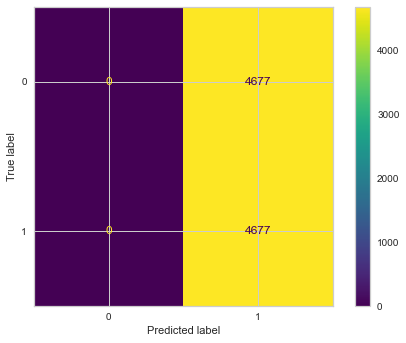

In [67]:
# Logistic Regression confusion matrix
lr_preds = lr.predict(x_train)
plot_confusion_matrix(lr, x_train, y_train)

In [33]:
#Light Gradient Boosting Machine which was the model with the best F1 score
from lightgbm import LGBMClassifier

parameters = {
    'max_depth':[3, 4, 5, 6, 10, 15,20,30],
    'num_leaves':[10,100,300,500,700,1000],
    'min_data_in_leaf': [10,100,300,500,700,1000]
}

lgbm = Pipeline([('CV', GridSearchCV(LGBMClassifier(), parameters, scoring='f1', cv=5))])
lgbm.fit(x_train, y_train)
lgbm.named_steps['CV'].best_params_

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

{'max_depth': 15, 'min_data_in_leaf': 10, 'num_leaves': 500}

In [75]:
%%time
#Light Gradient Boosting Machine

lgbm = LGBMClassifier(max_depth=15, min_data_in_leaf=10, num_leaves=500).fit(x_train, y_train)
lgbm_scores = cross_val_score(lgbm, x_train, y_train, cv=10, scoring="f1")
np.mean(lgbm_scores)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

0.9138660232906949

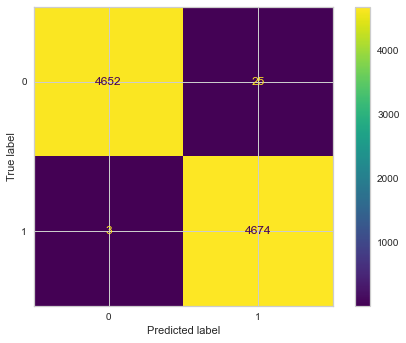

In [76]:
# Light Gradient Booster confusion matrix
plot_confusion_matrix(lgbm, x_train, y_train)

In [68]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[3, 4, 5, 6, 10, 15,20,30],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, scoring='f1',cv=10))])
dtc.fit(x_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 20}

In [69]:
%%time
# Decision Tree Classifier
dtc = DecisionTreeClassifier(max_depth=20).fit(x_train, y_train)
dt_scores = cross_val_score(dtc, x_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

Wall time: 1.04 s


0.8215242015209722

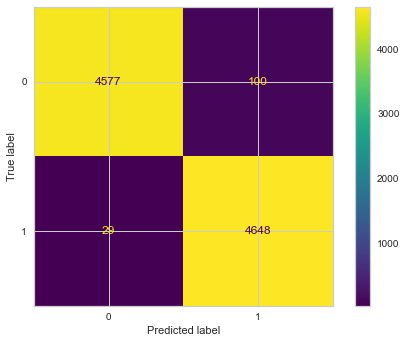

In [70]:
# Decision Tree Classifier confusion matrix
plot_confusion_matrix(dtc, x_train, y_train)

In [71]:
%%time
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[3, 6,12,15,20],
    'n_estimators':[10, 20,30]
}
clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(), parameters, cv = 10, scoring='f1'))])
clf.fit(x_train, y_train)
clf.named_steps['CV'].best_params_

Wall time: 39.8 s


{'max_depth': 20, 'n_estimators': 30}

In [72]:
%%time
# RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 30, max_depth = 20).fit(x_train, y_train))])
rf_scores = cross_val_score(rf, x_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

Wall time: 5.79 s


0.8971286145854076

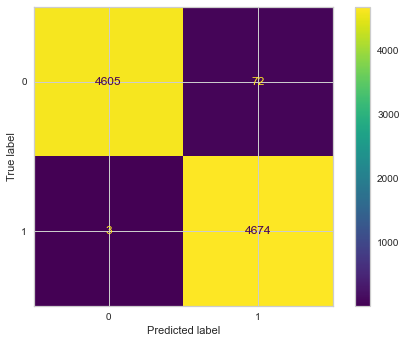

In [73]:
# Random Forest Classifier confusion matrix
plot_confusion_matrix(rf, x_train, y_train)

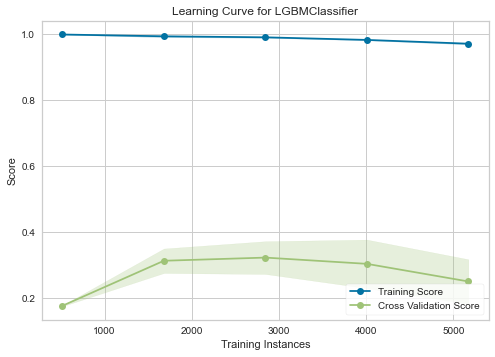

<AxesSubplot:title={'center':'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [40]:
from yellowbrick.model_selection import LearningCurve
lc = LearningCurve(lgbm, scoring='f1')
lc.fit(X, y)
lc.show()

The Light Gradient Boosting Machine had the best F1 score with Random Forest Classifier, Decision Tree and Logistic Regression following.

Therefore, I will be using the Light Gradient Boosting Machine as my recommendation algorithm.

In [44]:
# Checking for imbalance
y_test.value_counts()

0    1170
1     123
Name: favorite, dtype: int64

In [45]:
# Building a pipeline to use on regular data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LGBMClassifier(max_depth=15, min_data_in_leaf=10, num_leaves=500))
pipe.fit(x_train, y_train)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbm', LGBMClassifier(max_depth=15, min_data_in_leaf=10, num_leaves=500))])

pipe.score(x_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


0.8793503480278422

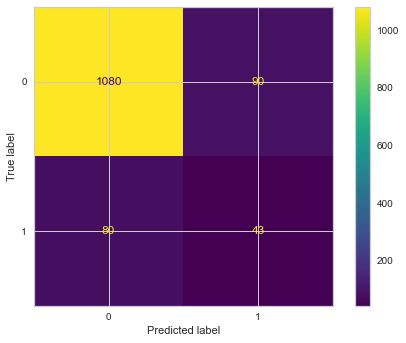

In [46]:
plot_confusion_matrix(rf, x_test, y_test)

In [47]:
# Reloading the original dataframe to test the model on
dfplaylist = pd.read_csv('Track Data Files for ML\SpotifyMarch22ML.csv')

In [76]:
dfplaylist.shape

(5847, 13)

In [49]:
# Predicting if a song is a favorite
prob_preds = pipe.predict_proba(dfplaylist.drop(['favorite', 'track_id', 'acousticness', 'time_signature'], axis=1))
threshold = 0.75 # define threshold here
preds = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]
dfplaylist['prediction'] = preds

In [50]:
dfplaylist['prediction'].value_counts()

0    5803
1      44
Name: prediction, dtype: int64

In [51]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2

In [80]:
# Insert your Spotify username and the credentials that you obtained from spotify developer
from Secret import *

cid = clientID
secret = clientSecret
redirect_uri='http://localhost:7777/callback'
username = 'c0wmilker247'

In [81]:
# Once the Authorisation is complete, we just need to `sp` to call the APIs
scope = 'user-top-read playlist-modify-private playlist-modify-public'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [54]:
# Creating a function that builds a playlist in the user's spotify account
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [77]:
create_playlist(sp, username, 'Electronic Playlist Recommendation V4', 'The tracks on this playlist were recommended from Spotify\'s electronic playlists with Light Gradient Boost.')

In [56]:
# Function to check if the playlist was created successfully
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [82]:
fetch_playlists(sp,username).head()

,id,name,#tracks
0,1rQyZ01E2JqZlwSl9H4bGd,Electronic Playlist Recommendation V4,44
1,4hdDF1ogSzYP2MvX5asa8o,Electronic Playlist Recommendation V3,39
2,6dI7t24AgApKE05Z2BABSg,Electronic Playlist Recommendation V2,29
3,47Tc322JWbOLKsoeJVd5HL,Antigone - Yotto Remix,10
4,5BKeJkILyINOCMng0vlvFf,Electronic Playlist Recommendation V1,30


In [78]:
# Getting the playlist ID of the most recently made playlist so we can add songs to it later
playlist_id = fetch_playlists(sp,username)['id'][0]

In [59]:
# Function to add selected songs to playlist
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 75])
        index += 75

In [79]:
# Adding songs to playlist
list_track = dfplaylist.loc[dfplaylist['prediction']  == 1]['track_id']
enrich_playlist(sp, username, playlist_id, list_track)